<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


# Metodología propuesta
#### 1. Selección del corpus:
Se seleccionó un corpus textual que sirviera como base para el entrenamiento del modelo de lenguaje. Este corpus debía ser representativo del dominio de interés y contener suficiente variabilidad léxica y sintáctica para permitir una generalización adecuada del modelo.

#### 2. Preprocesamiento del texto:
El corpus fue sometido a un proceso de preprocesamiento que incluyó:
* Conversión a minúsculas.
* Tokenización carácter a carácter.
* Codificación de los caracteres mediante índices enteros.
* Estructuración del conjunto de datos en secuencias de longitud fija.
* División en conjuntos de entrenamiento y validación.

#### 3. Diseño del modelo:
Se exploraron distintas arquitecturas de redes neuronales recurrentes para la tarea de modelado de lenguaje. En particular, se evaluaron modelos basados en *SimpleRNN*, *LSTM* y *GRU*, integrando capas de proyección y activación, y utilizando codificación *one-hot* como representación de entrada.

#### 4. Entrenamiento:
Los modelos fueron entrenados aplicando la perplejidad desde un *Callback ad-hoc*.

#### 5. Generación de texto
Los modelos entrenados fueron utilizados para generar nuevas secuencias a partir de contextos semilla. Se implementaron distintas estrategias de decodificación:
* *Greedy search:* selección del carácter más probable en cada paso.
* *Beam search determinista:* exploración de múltiples trayectorias con selección sistemática de los mejores candidatos.
* *Beam search estocástico:* incorporación de muestreo probabilístico controlado mediante un parámetro de temperatura, permitiendo analizar su impacto en la diversidad y coherencia de las secuencias generadas.

#### 6. Conclusiones: 
Se genearon las principales conclusiones basada en los resultados encontrados. 


In [ ]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.sequence import pad_sequences


## 1. Selección del corpus
Se utilizó un conjunto de datos publicado en Kaggle, titulado ArXiv Scientific Research Papers Dataset, compuesto por artículos del repositorio arXiv en áreas como inteligencia artificial, aprendizaje automático, informática y matemáticas.

Para este trabajo, se seleccionaron los primeros 10.000 títulos y resúmenes, los cuales fueron compilados en un único texto para su análisis.

El dataset incluía campos como título, resumen, categoría, autores y fechas de publicación y actualización. Fue utilizado previamente en tareas como clasificación de textos, sistemas de recomendación, análisis de tendencias, resumen automático, modelado de temas y análisis de impacto de autores.

Disponible en:
https://www.kaggle.com/datasets/sumitm004/arxiv-scientific-research-papers-dataset



In [1]:
import io
import pandas as pd

# Conjunto de datos como archivo CSV    
dataset = pd.read_csv('./data/arXiv_scientific dataset.csv') 

# Eliminación de ariticulos repetidos 'title' 
dataset = dataset.drop_duplicates(subset='title', keep='first') 

dataset = dataset.sort_values(by='title')

dataset

,id,title,category,category_code,published_date,updated_date,authors,first_author,summary,summary_word_count
121694,abs-2105.05542v1,!Qué maravilla! Multimodal Sarcasm Detection i...,Computation and Language (Natural Language Pro...,cs.CL,5/12/21,5/12/21,"['Khalid Alnajjar', 'Mika Hämäläinen']",'Khalid Alnajjar',We construct the first ever multimodal sarcasm...,101
122663,abs-2112.13800v1,"""A Passage to India"": Pre-trained Word Embeddi...",Computation and Language (Natural Language Pro...,cs.CL,12/27/21,12/27/21,"['Kumar Saurav', 'Kumar Saunack', 'Diptesh Kan...",'Kumar Saurav',Dense word vectors or 'word embeddings' which ...,198
126865,abs-2310.07155v2,"""A Tale of Two Movements"": Identifying and Com...",Computation and Language (Natural Language Pro...,cs.CL,10/11/23,10/21/23,"['Shamik Roy', 'Dan Goldwasser']",'Shamik Roy',Social media has become a major driver of soci...,159
20236,abs-2305.13252v2,"""According to ..."": Prompting Language Models ...",Computation and Language (Natural Language Pro...,cs.CL,5/22/23,2/26/24,"['Orion Weller', 'Marc Marone', 'Nathaniel Wei...",'Orion Weller',Large Language Models (LLMs) may hallucinate a...,126
20126,abs-2305.05597v1,"""Alexa doesn't have that many feelings"": Child...",Human-Computer Interaction,cs.HC,5/9/23,5/9/23,"['Valentina Andries', 'Judy Robertson']",'Valentina Andries',As voice-based Conversational Assistants (CAs)...,169
...,...,...,...,...,...,...,...,...,...,...
27869,abs-1512.04469v1,Über die Klassifizierung von Knoten in dynamis...,Machine Learning,cs.LG,11/23/15,11/23/15,['Martin Thoma'],'Martin Thoma',This paper explains the DYCOS-Algorithm as it ...,248
19932,abs-2304.09944v1,Überprüfung von Integritätsbedingungen in Dedu...,Databases,cs.DB,3/21/23,3/21/23,['Stefan Decker'],'Stefan Decker',Advancements in computer science and AI lead t...,168
13848,abs-2110.15764v1,ε-weakened Robustness of Deep Neural Networks,Machine Learning,cs.LG,10/29/21,10/29/21,"['Pei Huang', 'Yuting Yang', 'Minghao Liu', 'F...",'Pei Huang',This paper introduces a notation of $\varepsil...,144
66050,abs-1708.01405v1,μ-MAR: Multiplane 3D Marker based Registration...,Computer Vision and Pattern Recognition,cs.CV,8/4/17,8/4/17,"['Marcelo Saval-Calvo', 'Jorge Azorin-Lopez', ...",'Marcelo Saval-Calvo',Many applications including object reconstruct...,296


/tmp/ipykernel_477976/150849843.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.values, y=top_categories.index, palette="viridis")


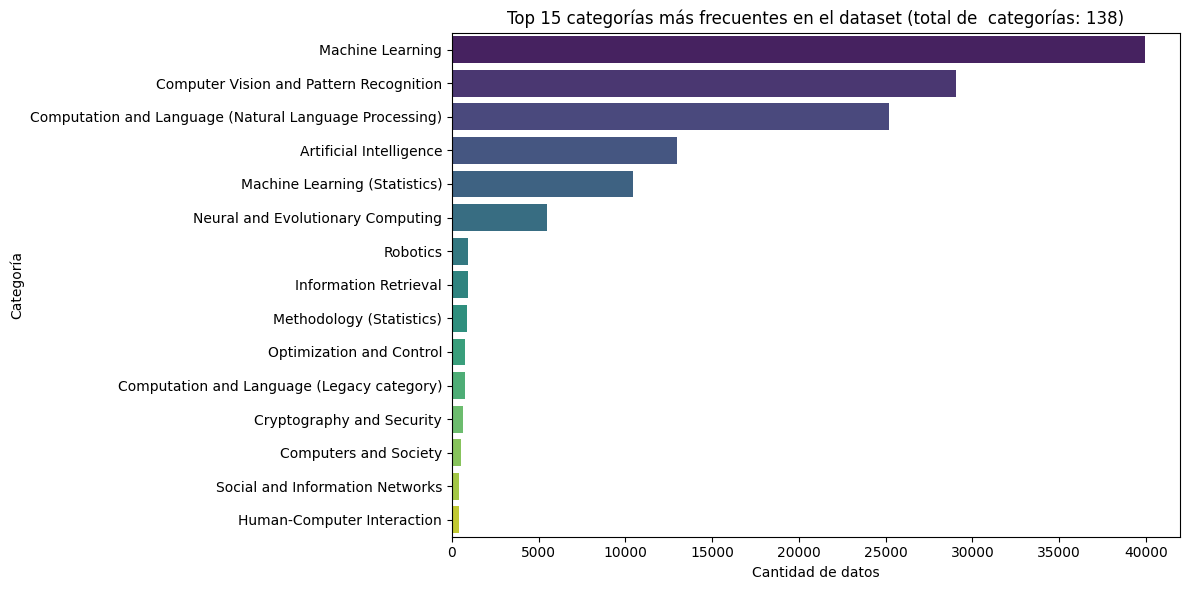

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

category_counts = dataset['category'].value_counts()
unique_categories = dataset['category'].unique()
total = 0
for i, category in enumerate(unique_categories, start=1):
    count = category_counts[category]
    total += 1
    #print(f"{i}. {category} : {count} data")

top_categories = category_counts.head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_categories.values, y=top_categories.index, palette="viridis")
plt.title(f'Top 15 categorías más frecuentes en el dataset (total de  categorías: {total})')
plt.xlabel('Cantidad de datos')
plt.ylabel('Categoría')
plt.tight_layout()
plt.savefig('./figures/top15_categories_hist.png')
plt.show()


**Figura 1.** Top 15 categorías más frecuentes en el dataset.

Como se puede ver en la figura 1 la mayor cantidad de datos son sobre aprendizaje de máquina (*Machine Learning*, ML) seguido de visión por computador (*Computer Vision*, CV) y procesamiento de lenguaje natural (*Natural Language Processing*, PNL). Por lo tanto, desde el corpus el modelo entrenado esta sesgado hacía los algoritmos y procesamientos de estas disciplinas, por ejemplo, red neuronal recurrente (*Recurrent Neural Network*, RNN) y convolucional (*Convolutional Neural Network*, CNN).

## 2. Preprocesamiento del texto
Se construyó un modelo de lenguaje carácter a carácter mediante una serie de pasos de preprocesamiento aplicados sobre un corpus textual:

* **Construcción del vocabulario:** se extrajo el conjunto único de caracteres presentes en el texto (chars_vocab) y se definieron diccionarios de mapeo (*char2idx* y *idx2char*) para convertir caracteres en índices enteros y viceversa. Esta codificación facilitó el tratamiento del texto como una secuencia numérica.

* **Tokenización:** el corpus completo fue tokenizado, es decir, cada carácter fue reemplazado por su correspondiente índice numérico según el vocabulario previamente definido.

* **División del dataset y creación de secuencias**
Para preparar los datos para el entrenamiento y la validación, el corpus tokenizado fue segmentado y estructurado de la siguiente manera.
    *  **División del corpus:** el corpus tokenizado fue dividido en un conjunto de entrenamiento (90%) y un conjunto de validación (10%). La porción de validación fue reservada del final del corpus para asegurar una evaluación objetiva.
    *  **Generación de secuencias:** se utilizó una ventana deslizante de 100 caracteres con stride = 1 para generar secuencias superpuestas de entrada (*X*) y sus correspondientes salidas (*y*) en el conjunto de entrenamiento. En validación, en cambio, se construyeron bloques consecutivos sin superposición. Las secuencias se estructuraron bajo un esquema *many-to-many*, en el que cada salida es la entrada desplazada un carácter hacia adelante.

#### Contrucción del vocabulario

Se construyó un corpus textual concatenando los títulos y resúmenes de los artículos en formato secuencial. Cada entrada fue estructurada colocando el título, seguido por un salto de línea (*\n*), el resumen correspondiente, otro salto de línea, y luego el siguiente título, repitiendo este patrón.

Para esta tarea, se seleccionaron aleatoriamente 500 artículos del conjunto de datos original, y se utilizó esta muestra para generar un *"book"* continuo de texto, que sirvió como base para los análisis posteriores.

In [3]:
import random
dataset = dataset.sample(100, random_state=42)  
article_text = ''
for index, row in dataset.iterrows():
    article_text += row['title'] + ' \n' + row['summary'] + ' \n'    
article_text = article_text.lower()
article_text[:1000]

'nonparametric bayesian deep networks with local competition \nthe aim of this work is to enable inference of deep networks that retain high\naccuracy for the least possible model complexity, with the latter deduced from\nthe data during inference. to this end, we revisit deep networks that comprise\ncompeting linear units, as opposed to nonlinear units that do not entail any\nform of (local) competition. in this context, our main technical innovation\nconsists in an inferential setup that leverages solid arguments from bayesian\nnonparametrics. we infer both the needed set of connections or locally\ncompeting sets of units, as well as the required floating-point precision for\nstoring the network parameters. specifically, we introduce auxiliary discrete\nlatent variables representing which initial network components are actually\nneeded for modeling the data at hand, and perform bayesian inference over them\nby imposing appropriate stick-breaking priors. as we experimentally show usin

En este caso se ve un texto sobre *ML* en el cual aparece un término especifico, *xgboost*, que es un algoritmo muy difundido en esta disciplina.

#### Preprocesamiento y codificación del Texto
Se definió un tamaño de contexto de 100 caracteres, que se utilizó como ventana deslizante para la generación de secuencias de entrada. El preprocesamiento del texto se llevó a cabo utilizando herramientas de la biblioteca Keras, en particular, la función *pad_sequences* fue incorporada para aplicar relleno (*padding*) en las secuencias cuando fue necesario (ver *./src/callback.py*).

El vocabulario se construyó a partir del conjunto único de caracteres presentes en el corpus completo (*article_text*). Luego, todos los caracteres fueron convertidos a minúsculas para reducir la dimensionalidad del vocabulario. Por último, a partir de este conjunto, se generaron dos diccionarios de mapeo:

- *char2idx*: asignó un índice numérico único a cada carácter (tokenización).

- *idx2char*: permitió la conversión inversa, de índices a caracteres.

La longitud total del vocabulario de caracteres fue registrada para ser utilizada en etapas posteriores del modelo de lenguaje.

In [4]:
# Definición del tamaño de contexto para las secuencias de entrada (número de caracteres utilizados como ventana de entrada)
# Se define un tamaño de contexto de 100 caracteres, por lo tanto, no es necesario utilizar padding (from tensorflow.keras.utils import pad_sequences) 
max_context_size = 100

# Extracción del vocabulario de caracteres: conjunto único de caracteres presentes en todo el corpus de texto
chars_vocab = set(article_text)

# Tamaño del vocabulario de caracteres
vocab_size = len(chars_vocab)

print(f'''
      El vacabulary de caracteres es: {chars_vocab}
      Número total de caracteres únicos en el conjunto de datos: {vocab_size}
''')



      El vacabulary de caracteres es: {'c', '1', 'r', '@', '-', '(', 'k', 'z', '}', '2', '9', '4', '>', 't', 'e', 'x', 'v', '\n', '.', 'q', '%', '8', '$', '^', ')', 'i', 's', '"', ';', '?', '=', ':', '{', 'h', 'm', 'a', 'd', 'u', 'n', ' ', 'p', 'f', 'w', 'j', 'o', 'g', '/', 'l', 'b', '7', '+', ',', '0', '5', '&', 'y', '6', '_', '3', '\\', "'"}
      Número total de caracteres únicos en el conjunto de datos: 61



In [5]:
# Construcción de los diccionarios de mapeo entre caracteres e índices numéricos
# `char2idx` actúa como tokenizador (carácter → índice)
char2idx = {k: v for v, k in enumerate(chars_vocab)}
print(f'char2idx (primeros 10): {list(char2idx.items())[:10]}')

# `idx2char` permite la conversión inversa (índice → carácter)
idx2char = {v: k for k, v in char2idx.items()}
print(f'idx2char (primeros 10): {list(idx2char.items())[:10]}')


char2idx (primeros 10): [('c', 0), ('1', 1), ('r', 2), ('@', 3), ('-', 4), ('(', 5), ('k', 6), ('z', 7), ('}', 8), ('2', 9)]
idx2char (primeros 10): [(0, 'c'), (1, '1'), (2, 'r'), (3, '@'), (4, '-'), (5, '('), (6, 'k'), (7, 'z'), (8, '}'), (9, '2')]


Como se puede ver en la primera tupla de la salida, *(1, @)*, el índice *1* se asocia con el carácter *@*. Esto significa que cuando el modelo encuentra el índice *1*, lo interpretará como el carácter *@*. Por lo tanto, al buscar el índice *1* en *idx2char*, se utiliza *1* como clave para mapear en el diccionario, y se devuelve su valor asociado que es el carácter *@*.

###  Tokenización

In [6]:
# Tokenización del texto completo: cada carácter del corpus se convierte en su índice correspondiente según el diccionario `char2idx`
tokenized_text = [char2idx[ch] for ch in article_text]

# Visualización de los primeros 1000 caracteres tokenizados
print(tokenized_text[:1000])


[38, 44, 38, 40, 35, 2, 35, 34, 14, 13, 2, 25, 0, 39, 48, 35, 55, 14, 26, 25, 35, 38, 39, 36, 14, 14, 40, 39, 38, 14, 13, 42, 44, 2, 6, 26, 39, 42, 25, 13, 33, 39, 47, 44, 0, 35, 47, 39, 0, 44, 34, 40, 14, 13, 25, 13, 25, 44, 38, 39, 17, 13, 33, 14, 39, 35, 25, 34, 39, 44, 41, 39, 13, 33, 25, 26, 39, 42, 44, 2, 6, 39, 25, 26, 39, 13, 44, 39, 14, 38, 35, 48, 47, 14, 39, 25, 38, 41, 14, 2, 14, 38, 0, 14, 39, 44, 41, 39, 36, 14, 14, 40, 39, 38, 14, 13, 42, 44, 2, 6, 26, 39, 13, 33, 35, 13, 39, 2, 14, 13, 35, 25, 38, 39, 33, 25, 45, 33, 17, 35, 0, 0, 37, 2, 35, 0, 55, 39, 41, 44, 2, 39, 13, 33, 14, 39, 47, 14, 35, 26, 13, 39, 40, 44, 26, 26, 25, 48, 47, 14, 39, 34, 44, 36, 14, 47, 39, 0, 44, 34, 40, 47, 14, 15, 25, 13, 55, 51, 39, 42, 25, 13, 33, 39, 13, 33, 14, 39, 47, 35, 13, 13, 14, 2, 39, 36, 14, 36, 37, 0, 14, 36, 39, 41, 2, 44, 34, 17, 13, 33, 14, 39, 36, 35, 13, 35, 39, 36, 37, 2, 25, 38, 45, 39, 25, 38, 41, 14, 2, 14, 38, 0, 14, 18, 39, 13, 44, 39, 13, 33, 25, 26, 39, 14, 38, 36, 5

Se obervan los primeros 1000 caracteres tokenizados en valores de índice del diccionario.

### División del dataset y creación de secuencias
Una vez completado el proceso de tokenización, el corpus numérico se dividió y estructuró para su uso en el entrenamiento y validación de cada modelo evaluado.

#### División del corpus
Para preparar los datos para el entrenamiento y la validación, el texto tokenizado se segmentó en dos subconjuntos. El 10% final del corpus se reservó para el conjunto de validación, mientras que el 90% restante se destinó al conjunto de entrenamiento. Por lo tanto, esto asegura que el modelo sea evaluado con datos que no ha visto durante el entrenamiento, proporcionando una medida objetiva de su capacidad de generalización.

In [7]:
import numpy as np
# Separación del dataset en entrenamiento y validación.
# Definición de la proporción del corpus que será reservada para validación
p_val = 0.1

# Cálculo del número de secuencias de longitud `max_context_size` destinadas a validación
num_val = int(np.ceil(len(tokenized_text) * p_val / max_context_size))

# División del corpus tokenizado en conjunto de entrenamiento y validación
# La parte final del corpus se reserva para validación; el resto se usa para entrenamiento
train_text = tokenized_text[:-num_val * max_context_size]
val_text = tokenized_text[-num_val * max_context_size:]


#### Generación de las secuencias
Las secuencias de entrada y salida fueron generadas para entrenar modelos de lenguaje de carácter a carácter. Según el propósito (entrenamiento o validación) fue la  estrategia aplicada en la creación de secuencias:

* Secuencias de entrenamiento (con superposición):
A partir del conjunto de entrenamiento, se utilizó una ventana deslizante con *stride = 1*, es decir, la ventana se muevió un carácter a la vez. Esto genera un gran número de secuencias altamente superpuestas, lo que permite al modelo ver múltiples contextos similares y mejorar su capacidad de generalización.

* Secuencias de validación (sin superposición):
Se generaron bloques consecutivos de longitud fija (*max_context_size*) a partir del conjunto de validación. Por lo tanto, cada bloque fue independiente, no hubo superposición entre ellos. Esta estructura es adecuada para evaluar el modelo de forma ordenada y sin redundancias durante el cálculo de métricas como la Perplejidad.

* Construcción de *X* e *y*:
Para cada secuencia de entrada *X[i]*, se asigna como salida esperada la siguiente secuencia *X[i+1]*. Esto permite que el modelo aprenda a predecir el siguiente carácter en una secuencia paso a paso, lo que se conoce como un enfoque many-to-many.

* Ejemplo:
Si *X[0] = [a, b, c]*, entonces *y[0] = [b, c, d]*.

In [8]:
# Generación de las secuencias de entrenamiento con una ventana deslizante (stride = 1)
tokenized_sentences_train = [
    train_text[init : init + max_context_size]
    for init in range(len(train_text) - max_context_size + 1)
]

# Generación de las secuencias de validación (sin superposición): bloques consecutivos de `max_context_size` caracteres
tokenized_sentences_val = [
    val_text[init * max_context_size : init * (max_context_size + 1)]
    for init in range(num_val)
]

# Construcción de los arrays de entrada (X) y salida (y) para entrenamiento supervisado
# Cada entrada X[i] se asocia con la siguiente secuencia de entrada X[i+1], que actúa como salida esperada
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

print(f'''
      Dimensión de X: {X.shape} y sus primeras 5 secuencias: {X[0,:5]},
      Dimension de y: {y.shape} y sus primeras 5 secuencias: {y[0,:5]},
      Tamaño del vocabulario: {vocab_size}
''')



      Dimensión de X: (109419, 100) y sus primeras 5 secuencias: [38 44 38 40 35],
      Dimension de y: (109419, 100) y sus primeras 5 secuencias: [44 38 40 35  2],
      Tamaño del vocabulario: 61



Se estructuró el problema de aprendizaje siguiendo un esquema *many-to-many*.

La entrada fue definida como una secuencia de tokens [$x_0$, $x_1$, ..., $x_N$], mientras que la salida objetivo correspondió a la misma secuencia desplazada una posición hacia adelante: [$x_1$, $x_2$, ..., $x_{N+1}$]. De este modo, se requería que la red aprendiera a predecir el carácter siguiente en cada paso temporal.

Al estructurarse el aprendizaje de esta forma, se permitió que una señal de gradiente se propagara en cada paso de la secuencia a lo largo del grafo de cómputo recurrente, lo cual resultó más eficiente que un enfoque many-to-one, en el que solo una única señal de error se propaga.

En esta etapa, las secuencias fueron tokenizadas y almacenadas en la variable *tokenized_sentences*. A partir de ellas, se extrajo un subconjunto que fue utilizado como conjunto de validación, con el fin de evaluar la calidad de las secuencias generadas mediante la métrica de Perplejidad.

## 3. Diseño del modelo:
Se implementaron y evaluaron tres arquitecturas recurrentes clásicas para modelado de lenguaje carácter a carácter: *SimpleRNN*, *LSTM* y *GRU*. Estas variantes permiten comparar el desempeño de diferentes mecanismos de memoria y control secuencial sobre el mismo conjunto de datos y tareas.

El modelo propuesto consume directamente índices enteros correspondientes a caracteres tokenizados, sin emplear una capa de embedding entrenable. En su lugar, la representación vectorial de cada carácter se realiza mediante codificación *one-hot* (OHE), aplicada a cada paso temporal de la secuencia.

Esta transformación se implementó combinando las siguientes capas de *Keras*:

- **CategoryEncoding:** transforma los índices enteros en vectores one-hot de dimensión igual al tamaño del vocabulario de caracteres.

- **TimeDistributed:** permite aplicar la codificación *one-hot* a cada paso temporal de la secuencia, preservando así la estructura secuencial del *input*.

Este diseño permite que la red procese la información carácter por carácter manteniendo la semántica temporal, sin incorporar una capa de embedding explícita.

In [9]:
# **Hiperparámetros de los modelos
VOCAB_SIZE = vocab_size
SEQUENCE_LENGTH = max_context_size
EMBEDDING_DIM = 50
RNN_UNITS = 64
DROPOUT_RATE = 0.3
PROJECTION_DIM = 32  # Es para GRU
ACTIVATION = 'relu'
OPTIMIZER_NAME = 'rmsprop'
LEARNING_RATE = 0.001



#### Arquitectura de la RNN simple

In [10]:
from src.architectures import SimpleRNNModel

simple_rnn_model = SimpleRNNModel(
    vocab_size=VOCAB_SIZE,
    sequence_length=SEQUENCE_LENGTH,
    rnn_units=RNN_UNITS,
    dropout_rate=DROPOUT_RATE,
    optimizer_name=OPTIMIZER_NAME,
    learning_rate=LEARNING_RATE
)
simple_rnn_model.build()
simple_rnn_model.summary()


2025-08-09 03:03:00.239443: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-09 03:03:00.256013: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754719380.270372  477976 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754719380.274726  477976 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754719380.289403  477976 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 100, 61)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 100, 64)        │         8,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100, 61)        │         3,965 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,029 (46.99 KB)

 Trainable params: 12,029 (46.99 KB)

 Non-trainable params: 0 (0.00 B)

#### Arquitectura de la GRU

In [11]:
from src.architectures import GRUModel

gru_model = GRUModel(
    vocab_size=VOCAB_SIZE,
    sequence_length=SEQUENCE_LENGTH,
    embedding_dim=EMBEDDING_DIM,
    rnn_units=RNN_UNITS,
    dropout_rate=DROPOUT_RATE,
    projection_dim=PROJECTION_DIM,
    optimizer_name=OPTIMIZER_NAME,
    learning_rate=LEARNING_RATE
)
gru_model.build()
gru_model.summary()

/home/adrian/miniconda3/envs/tf_minimal_env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 50)        │         3,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 100, 64)        │        22,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 100, 64)        │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100, 32)        │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100, 62)        │         2,046 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,458 (212.73 KB)

 Trainable params: 54,458 (212.73 KB)

 Non-trainable params: 0 (0.00 B)

#### Arquitectura de la LSTM

In [12]:
from src.architectures import LSTMModel

lstm_model = LSTMModel(
    vocab_size=VOCAB_SIZE,
    sequence_length=SEQUENCE_LENGTH,
    embedding_dim=EMBEDDING_DIM,
    rnn_units=RNN_UNITS,
    dropout_rate=DROPOUT_RATE,
    projection_dim=PROJECTION_DIM,
    optimizer_name=OPTIMIZER_NAME,
    learning_rate=LEARNING_RATE
)
lstm_model.build()
lstm_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 50)        │         3,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100, 64)        │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100, 32)        │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100, 62)        │         2,046 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,690 (272.23 KB)

 Trainable params: 69,690 (272.23 KB)

 Non-trainable params: 0 (0.00 B)

### Callbacks
En *src/PplCallback* fue desarrollado un *Callback ad-hoc* para el cálculo de la perplejidad, funcionando como una herramienta de monitorización y control del entrenamiento. Su diseño fue concebido para abordar las limitaciones de las métricas de pérdida estándar de *Keras* en el modelado de lenguaje. Este *Callback ad-hoc* fue integrado en el bucle de entrenamiento con el fin de proporcionar un seguimiento detallado y una gestión eficiente del proceso de aprendizaje.

**Las principales ventajas de esta implementación fueron las siguientes:**

Evaluación cuantitativa mediante perplejidad: a diferencia de la pérdida de entropía cruzada, la perplejidad fue utilizada como una medida más intuitiva del rendimiento de un modelo de lenguaje. El *Callback ad-hoc* fue encargado de calcular la perplejidad sobre un conjunto de validación al final de cada época, utilizando la fórmula:

$$
\mathrm{PPL}(X) = \exp\left( -\frac{1}{t} \sum_{i=1}^{t} \log p_{\theta}\left( w_i \,\middle|\, w_{<i} \right) \right)
$$


donde $PPL$ es la perplejidad calculada con la probabilidad de *Cross-entropy* ($p_{\theta}$) predicha por el modelo para el token objetivo. Esto fue así por cuestiones de estabilidad numérica, ya que conviene operar sobre los logaritmos de las probabilidades. Por lo tanto, este enfoque proporcionó un criterio robusto para evaluar la capacidad de generalización del modelo.

**Detención temprana (*Early Stopping*):** una estrategia de *Early Stopping* basada en el monitoreo de la perplejidad fue implementada en el PplCallback. El valor mínimo de perplejidad (*min_score*) fue registrado, y el entrenamiento fue interrumpido de forma anticipada si dicha métrica no mejoraba durante un número predefinido de épocas (*patience*). Esta funcionalidad fue considerada crítica para evitar el sobreajuste (*overfitting*), situación en la cual el modelo comenzaba a memorizar los datos de entrenamiento en detrimento de su capacidad de generalización.

**Persistencia del mejor modelo:** el modelo fue guardado automáticamente por el *Callback ad-hoc* cada vez que se observó una nueva perplejidad mínima en los datos de validación. Esta característica aseguró que la versión final del modelo conservada fuera aquella con el mejor desempeño de generalización, lo cual fue fundamental para el análisis de los resultados y la replicabilidad de los hallazgos. El nombre del archivo pudo ser configurado mediante el parámetro *model_name*.

**Registro de historial:** el historial de perplejidad fue almacenado en una lista (*history_ppl*), lo que permitió un análisis post-mortem y una visualización clara del proceso de aprendizaje. Esto facilitó la identificación de la época óptima de entrenamiento y la comparación del desempeño entre diferentes arquitecturas de red.


## 4. Entrenamiento de los modelos

In [16]:
from src.callbacks import PplCallback

BATCH_SIZE = 256
EPOCHS = 50
PATIENCE = 3

In [17]:
# Entrenamiento del modelo SimpleRNN
history_ppl_rnn = []
ppl_callback_rnn = PplCallback(
    val_data=tokenized_sentences_val,
    history_ppl=history_ppl_rnn,
    maxlen=SEQUENCE_LENGTH,
    model_name='models/simple_rnn_model',
    patience=PATIENCE
)

[INFO] Forma del conjunto validación: (7239, 100)
[INFO] Total de subsecuencias procesadas: 7239
[INFO] Longitud máxima de secuencia: 100


In [18]:


hist_rnn = simple_rnn_model.model.fit(
    X,
    y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[ppl_callback_rnn]
)


Epoch 1/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2609 - loss: 2.5349[EPOCH 1] Perplejidad media en validación: 10.2981
[GUARDADO] Nuevo modelo con mejor perplejidad (10.2981) almacenado como 'models/simple_rnn_model.keras'
428/428 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.2609 - loss: 2.5349
Epoch 2/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2782 - loss: 2.4691[EPOCH 2] Perplejidad media en validación: 9.6748
[GUARDADO] Nuevo modelo con mejor perplejidad (9.6748) almacenado como 'models/simple_rnn_model.keras'
428/428 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2782 - loss: 2.4690
Epoch 3/50
427/428 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2892 - loss: 2.4276[EPOCH 3] Perplejidad media en validación: 9.4346
[GUARDADO] Nuevo modelo con mejor perplejidad (9.4346) almacenado como 'models/simple_rnn_model.keras'
428/428 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2892 - loss: 2.4276
Epoch 4/50
426/428 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 

In [19]:
# Entrenamiento del modelo GRU
history_ppl_gru = []
ppl_callback_gru = PplCallback(
    val_data=tokenized_sentences_val,
    history_ppl=history_ppl_gru,
    maxlen=SEQUENCE_LENGTH,
    model_name='models/gru_model',
    patience=PATIENCE
)

[INFO] Forma del conjunto validación: (7239, 100)
[INFO] Total de subsecuencias procesadas: 7239
[INFO] Longitud máxima de secuencia: 100


In [20]:
hist_gru = gru_model.model.fit(
    X,
    y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[ppl_callback_gru]
)


Epoch 1/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - accuracy: 0.1507 - loss: 3.0930[EPOCH 1] Perplejidad media en validación: 12.7732
[GUARDADO] Nuevo modelo con mejor perplejidad (12.7732) almacenado como 'models/gru_model.keras'
428/428 ━━━━━━━━━━━━━━━━━━━━ 367s 846ms/step - accuracy: 0.1509 - loss: 3.0924
Epoch 2/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 735ms/step - accuracy: 0.2974 - loss: 2.4281[EPOCH 2] Perplejidad media en validación: 10.7229
[GUARDADO] Nuevo modelo con mejor perplejidad (10.7229) almacenado como 'models/gru_model.keras'
428/428 ━━━━━━━━━━━━━━━━━━━━ 349s 816ms/step - accuracy: 0.2974 - loss: 2.4279
Epoch 3/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 735ms/step - accuracy: 0.3643 - loss: 2.1701[EPOCH 3] Perplejidad media en validación: 8.5790
[GUARDADO] Nuevo modelo con mejor perplejidad (8.5790) almacenado como 'models/gru_model.keras'
428/428 ━━━━━━━━━━━━━━━━━━━━ 349s 815ms/step - accuracy: 0.3643 - loss: 2.1700
Epoch 4/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 739ms/step - accu

In [21]:
# Entrenamiento del modelo LSTM
history_ppl_lstm = []

ppl_callback_lstm = PplCallback(
    val_data=tokenized_sentences_val,
    history_ppl=history_ppl_lstm,
    maxlen=SEQUENCE_LENGTH,
    model_name='models/lstm_model', 
    patience=PATIENCE
)

[INFO] Forma del conjunto validación: (7239, 100)
[INFO] Total de subsecuencias procesadas: 7239
[INFO] Longitud máxima de secuencia: 100


In [22]:
hist_lstm = lstm_model.model.fit(
    X,
    y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[ppl_callback_lstm]
)

Epoch 1/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1195 - loss: 3.1906[EPOCH 1] Perplejidad media en validación: 17.6902
[GUARDADO] Nuevo modelo con mejor perplejidad (17.6902) almacenado como 'models/lstm_model.keras'
428/428 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.1195 - loss: 3.1903
Epoch 2/50
427/428 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1758 - loss: 2.8137[EPOCH 2] Perplejidad media en validación: 15.2940
[GUARDADO] Nuevo modelo con mejor perplejidad (15.2940) almacenado como 'models/lstm_model.keras'
428/428 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.1758 - loss: 2.8135
Epoch 3/50
426/428 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2486 - loss: 2.5975[EPOCH 3] Perplejidad media en validación: 12.0108
[GUARDADO] Nuevo modelo con mejor perplejidad (12.0108) almacenado como 'models/lstm_model.keras'
428/428 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.2487 - loss: 2.5971
Epoch 4/50
426/428 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy:

**Comparación de la Perplejidad entre los diferentes modelos explorado**

In [45]:
print(hist_lstm)

In [42]:
history_ppl_rnn

[np.float64(10.298123594125112),
 np.float64(9.674785578250885),
 np.float64(9.434616708755494),
 np.float64(9.181677565972011),
 np.float64(8.974889838695526),
 np.float64(8.783732573191324),
 np.float64(8.79477636416753),
 np.float64(8.847414010763169),
 np.float64(8.732633272806803),
 np.float64(8.799533740679424),
 np.float64(8.805853966871897),
 np.float64(8.797049850225449)]

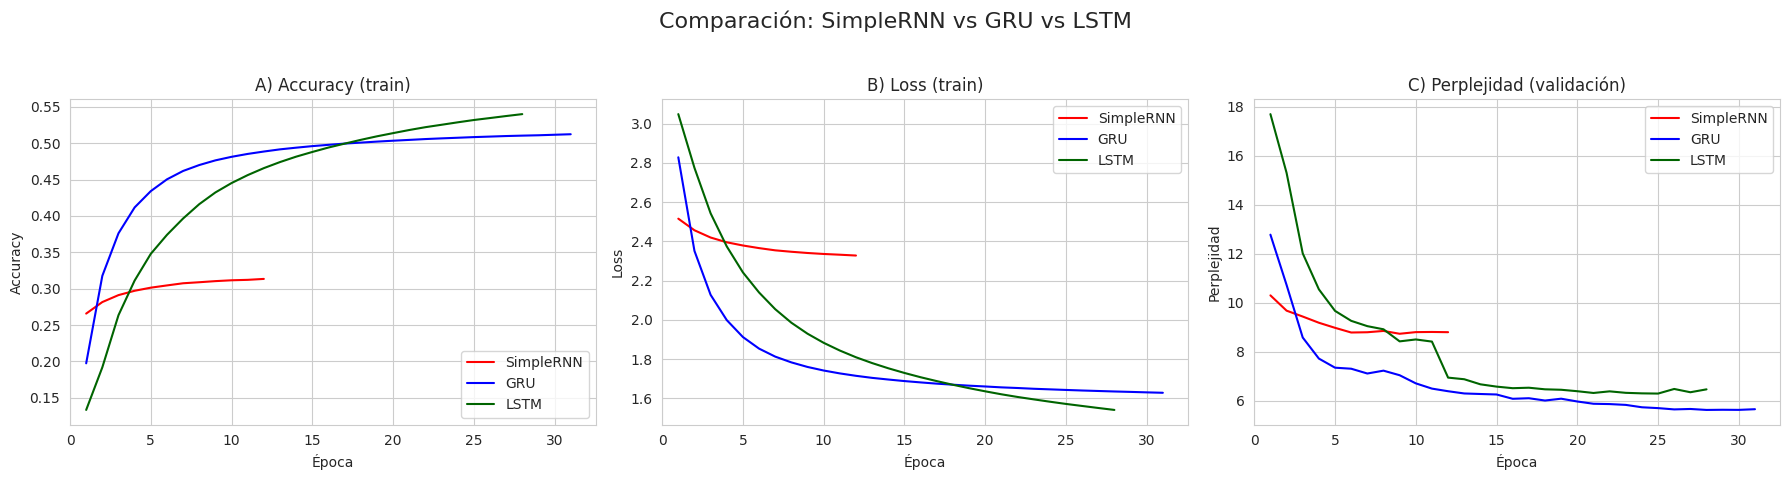

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Extraer curvas reales de Keras (train) ---
acc_rnn  = hist_rnn.history.get('accuracy', [])
loss_rnn = hist_rnn.history.get('loss', [])

acc_gru  = hist_gru.history.get('accuracy', [])
loss_gru = hist_gru.history.get('loss', [])

acc_lstm  = hist_lstm.history.get('accuracy', [])
loss_lstm = hist_lstm.history.get('loss', [])

# --- Perplejidad desde tus callbacks (validación) ---
ppl_rnn  = history_ppl_rnn
ppl_gru  = history_ppl_gru
ppl_lstm = history_ppl_lstm

# Ejes x por modelo (1..n_epochs_reales)
epochs_acc_rnn  = np.arange(1, len(acc_rnn)  + 1)
epochs_acc_gru  = np.arange(1, len(acc_gru)  + 1)
epochs_acc_lstm = np.arange(1, len(acc_lstm) + 1)

epochs_loss_rnn  = np.arange(1, len(loss_rnn)  + 1)
epochs_loss_gru  = np.arange(1, len(loss_gru)  + 1)
epochs_loss_lstm = np.arange(1, len(loss_lstm) + 1)

epochs_ppl_rnn  = np.arange(1, len(ppl_rnn)  + 1)
epochs_ppl_gru  = np.arange(1, len(ppl_gru)  + 1)
epochs_ppl_lstm = np.arange(1, len(ppl_lstm) + 1)

# --- Figura ---
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
sns.set_style("whitegrid")
x_max = max([*epochs_ppl_rnn[-1:], *epochs_ppl_gru[-1:], *epochs_ppl_lstm[-1:]]) * 1.05

# ---------------- A) ACCURACY (train) ----------------
ax1 = axes[0]
sns.lineplot(x=epochs_acc_rnn,  y=acc_rnn,  label='SimpleRNN', color='red', ax=ax1)
sns.lineplot(x=epochs_acc_gru,  y=acc_gru,  label='GRU', color='blue', ax=ax1)
sns.lineplot(x=epochs_acc_lstm, y=acc_lstm, label='LSTM', color='darkgreen', ax=ax1)

ax1.set_title('A) Accuracy (train)')
ax1.set_xlabel('Época')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.set_xlim(0, x_max)

# ---------------- B) LOSS (train) ----------------
ax2 = axes[1]
sns.lineplot(x=epochs_loss_rnn,  y=loss_rnn,  label='SimpleRNN', color='red', ax=ax2)
sns.lineplot(x=epochs_loss_gru,  y=loss_gru,  label='GRU', color='blue', ax=ax2)
sns.lineplot(x=epochs_loss_lstm, y=loss_lstm, label='LSTM', color='darkgreen', ax=ax2)

ax2.set_title('B) Loss (train)')
ax2.set_xlabel('Época')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.set_xlim(0, x_max)

# ---------------- C) PERPLEJIDAD (validación) ----------------
ax3 = axes[2]
sns.lineplot(x=epochs_ppl_rnn,  y=ppl_rnn,  label='SimpleRNN', color='red', ax=ax3)
sns.lineplot(x=epochs_ppl_gru,  y=ppl_gru,  label='GRU', color='blue', ax=ax3)
sns.lineplot(x=epochs_ppl_lstm, y=ppl_lstm, label='LSTM', color='darkgreen', ax=ax3)

ax3.set_title('C) Perplejidad (validación)')
ax3.set_xlabel('Época')
ax3.set_ylabel('Perplejidad')
ax3.legend()
ax3.set_xlim(0, x_max)

# (opcional): si las PPL son grandes, descomenta para escala log
# ax3.set_yscale('log')

plt.suptitle('Comparación: SimpleRNN vs GRU vs LSTM', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('model_comparison.png', dpi=150)
plt.show()


In [53]:
import json

# Guardar char2idx en un archivo JSON
with open('./models/char2idx.json', 'w') as f:
    json.dump(char2idx, f)
    
# Guardar idx2char en un archivo JSON
with open('./models/idx2char.json', 'w') as f:
    json.dump(idx2char, f)

## 5. Generación de texto
Los modelos entrenados fueron utilizados para generar nuevas secuencias a partir de pseudotextos. Se implementaron distintas estrategias de decodificación:


In [57]:
from tensorflow import keras
import json
# Para hacer inferencia, se cargan los diccionarios y los mejores modelos guardados durante el entrenamiento 


with open('./models/char2idx.json', 'r') as f:
    char2idx = json.load(f)

with open('./models/idx2char.json', 'r') as f:
    idx2char = json.load(f)

# convertir claves a int
if isinstance(idx2char, dict):
    idx2char = {int(k): v for k, v in idx2char.items()}

    
simple_rnn_model = keras.models.load_model('./models/simple_rnn_model.keras')
gru_model = keras.models.load_model('./models/gru_model.keras')
lstm_model = keras.models.load_model('./models/lstm_model.keras')

In [58]:
input_text_1 = 'recurrent neural network'
input_text_2 = 'convolutional neural network'
input_text_3 = 'future researchs should'


### Predicción del próximo caracter

In [59]:
from src.text_generator import generate_seq

print (f'''
       para "recurrent neural network" la RNN simple responde:
       {generate_seq(simple_rnn_model, input_text_1, char2idx=char2idx, idx2char= idx2char, max_length=max_context_size, n_words=100)}
''')

print (f'''
       para "convolutional neural network" la RNN simple responde:
       {generate_seq(simple_rnn_model, input_text_2, char2idx=char2idx, idx2char= idx2char, max_length=max_context_size, n_words=100)}
''')

print (f'''
       para "future researchs should" la RNN simple responde:
       {generate_seq(simple_rnn_model, input_text_3, char2idx=char2idx, idx2char= idx2char, max_length=max_context_size, n_words=100)}
''')



       para "recurrent neural network" la RNN simple responde:
       recurrent neural network the proposed the proposed the proposed the proposed the proposed the proposed the proposed the prop


       para "convolutional neural network" la RNN simple responde:
       convolutional neural network the proposed the proposed the proposed the proposed the proposed the proposed the proposed the prop


       para "future researchs should" la RNN simple responde:
       future researchs should the proposed the proposed the proposed the proposed the proposed the proposed the proposed the prop



In [60]:
from src.text_generator import generate_seq

print (f'''
       para "recurrent neural network" la GRU responde:
       {generate_seq(gru_model, input_text_1, char2idx=char2idx, idx2char= idx2char, max_length=max_context_size, n_words=100)}
''')

print (f'''
       para "convolutional neural network" la GRU responde:
       {generate_seq(gru_model, input_text_2, char2idx=char2idx, idx2char= idx2char, max_length=max_context_size, n_words=100)}
''')

print (f'''
       para "future researchs should" la GRU responde:
       {generate_seq(gru_model, input_text_3, char2idx=char2idx, idx2char= idx2char, max_length=max_context_size, n_words=100)}
''')


       para "recurrent neural network" la GRU responde:
       recurrent neural networks and the set and the set and the set and the set and the set and the set and the set and the set an


       para "convolutional neural network" la GRU responde:
       convolutional neural networks and the set and the set and the set and the set and the set and the set and the set and the set an


       para "future researchs should" la GRU responde:
       future researchs should the set and the set and the set and the set and the set and the set and the set and the set and the



In [61]:
from src.text_generator import generate_seq

print (f'''
       para "recurrent neural network" la lstm responde:
       {generate_seq(lstm_model, input_text_1, char2idx=char2idx, idx2char= idx2char, max_length=max_context_size, n_words=100)}
''')

print (f'''
       para "convolutional neural network" la lstm responde:
       {generate_seq(lstm_model, input_text_2, char2idx=char2idx, idx2char= idx2char, max_length=max_context_size, n_words=100)}
''')

print (f'''
       para "future researchs should" la lstm responde:
       {generate_seq(lstm_model, input_text_3, char2idx=char2idx, idx2char= idx2char, max_length=max_context_size, n_words=100)}
''')


       para "recurrent neural network" la lstm responde:
       recurrent neural networks of the structure and the structure and the structure and the structure and the structure and the s


       para "convolutional neural network" la lstm responde:
       convolutional neural networks of the structure and the structure and the structure and the structure and the structure and the s


       para "future researchs should" la lstm responde:
       future researchs should the structure and the structure and the structure and the structure and the structure and the struc



###  Beam search y muestreo aleatorio

#### Determinístico

In [ ]:
# predicción con beam search
from src.text_generator import beam_search, decode

salidas_1 = beam_search(simple_rnn_model, num_beams=5, num_words=100,input_text=input_text_1, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=1, mode='det')

salidas_2 = beam_search(simple_rnn_model, num_beams=5, num_words=100, input_text=input_text_2, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=1, mode='det')

salidas_3 = beam_search(simple_rnn_model, num_beams=5, num_words=100, input_text=input_text_3, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=1, mode='det')

print (f'''
       para "recurrent neural network" la RNN simple responde:
       {decode(salidas_1[0], idx2char)}
''')

print (f'''
       para "convolutional neural network" la RNN simple responde:
       {decode(salidas_2[0], idx2char)}
''')

print (f'''
       para "future researchs should" la RNN simple responde:
       {decode(salidas_3[0], idx2char)}
''')



       para "recurrent neural network" la RNN simple responde:
       recurrent neural network of the proposed the proposed the proposed the proposed the proposed the proposed the proposed the p


       para "convolutional neural network" la RNN simple responde:
       convolutional neural network of the proposed the proposed the proposed the proposed the proposed the proposed the proposed the p


       para "future researchs should" la RNN simple responde:
       future researchs should and the proposed the proposed the proposed the proposed the proposed the proposed the proposed the 



In [ ]:
# predicción con beam search
from src.text_generator import beam_search, decode

salidas_1 = beam_search(gru_model, num_beams=5, num_words=100, input_text=input_text_1, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=1, mode='det')

salidas_2 = beam_search(gru_model, num_beams=5, num_words=100, input_text=input_text_2, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=1, mode='det')

salidas_3 = beam_search(gru_model, num_beams=5, num_words=100, input_text=input_text_3, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=1, mode='det')

print (f'''
       para "recurrent neural network" la GRU responde:
       {decode(salidas_1[0], idx2char)}
''')

print (f'''
       para "convolutional neural network" la GRU responde:
       {decode(salidas_2[0], idx2char)}
''')

print (f'''
       para "future researchs should" la GRU responde:
       {decode(salidas_3[0], idx2char)}
''')


       para "recurrent neural network" la GRU responde:
       recurrent neural networks of the proposed the problems. we proposed the problems. we proposed the problems. we proposed the 


       para "convolutional neural network" la GRU responde:
       convolutional neural networks of the proposed the problems. we proposed the problems. we proposed the problems. we proposed the 


       para "future researchs should" la GRU responde:
       future researchs should the problems. we proposed the problems. we proposed the problems. we proposed the proposed and the 



In [64]:
# predicción con beam search
from src.text_generator import beam_search, decode

salidas_1 = beam_search(lstm_model, num_beams=5, num_words=100, input_text=input_text_1, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=1, mode='det')

salidas_2 = beam_search(lstm_model, num_beams=5, num_words=100, input_text=input_text_2, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=1, mode='det')

salidas_3 = beam_search(lstm_model, num_beams=5, num_words=100, input_text=input_text_3, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=1, mode='det')

print (f'''
       para "recurrent neural network" la LSTM responde:
       {decode(salidas_1[0], idx2char)}
''')

print (f'''
       para "convolutional neural network" la LSTM responde:
       {decode(salidas_2[0], idx2char)}
''')

print (f'''
       para "future researchs should" la LSTM responde:
       {decode(salidas_3[0], idx2char)}
''')



       para "recurrent neural network" la LSTM responde:
       recurrent neural networks of the proposed the proposed the proposed the proposed the proposed the proposed the proposed the 


       para "convolutional neural network" la LSTM responde:
       convolutional neural networks of the proposed the proposed the proposed the proposed the proposed the proposed the proposed the 


       para "future researchs should" la LSTM responde:
       future researchs should the proposed the proposed the proposed the proposed the proposed the proposed the proposed the prop



#### Estocástico

**Temperatura baja**

In [65]:
# predicción con beam search
from src.text_generator import beam_search, decode

TEMP = 2

salidas_1 = beam_search(simple_rnn_model, num_beams=5, num_words=100,input_text=input_text_1, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

salidas_2 = beam_search(simple_rnn_model, num_beams=5, num_words=100, input_text=input_text_2, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

salidas_3 = beam_search(simple_rnn_model, num_beams=5, num_words=100, input_text=input_text_3, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

print (f'''
       para "recurrent neural network" la RNN simple responde:
       {decode(salidas_1[0], idx2char)}
''')

print (f'''
       para "convolutional neural network" la RNN simple responde:
       {decode(salidas_2[0], idx2char)}
''')

print (f'''
       para "future researchs should" la RNN simple responde:
       {decode(salidas_3[0], idx2char)}
''')



       para "recurrent neural network" la RNN simple responde:
       recurrent neural network prietetionallysition, we bimizat signe piparass. treal terresecalign grions teet retw-glem. we algm


       para "convolutional neural network" la RNN simple responde:
       convolutional neural network 
ment baudial reas ing londesemens on hity resettininifing morle exaiceleatiod by
hoced that
im
esc


       para "future researchs should" la RNN simple responde:
       future researchs should
in annancy bates artiotality to onration oatals to the gordifur dachisenialithe mase ne
met in tral



In [66]:
# predicción con beam search
from src.text_generator import beam_search, decode

TEMP = 2

salidas_1 = beam_search(gru_model, num_beams=5, num_words=100, input_text=input_text_1, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

salidas_2 = beam_search(gru_model, num_beams=5, num_words=100, input_text=input_text_2, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

salidas_3 = beam_search(gru_model, num_beams=5, num_words=100, input_text=input_text_3, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

print (f'''
       para "recurrent neural network" la GRU responde:
       {decode(salidas_1[0], idx2char)}
''')

print (f'''
       para "convolutional neural network" la GRU responde:
       {decode(salidas_2[0], idx2char)}
''')

print (f'''
       para "future researchs should" la GRU responde:
       {decode(salidas_3[0], idx2char)}
''')


       para "recurrent neural network" la GRU responde:
       recurrent neural network recognitring archieves not
rank superviestly learning
the models achisting
inferation algorithms ov


       para "convolutional neural network" la GRU responde:
       convolutional neural network a new the
sytep resolving
connection
we such data,
which learning reson-of improves to are most to 


       para "future researchs should" la GRU responde:
       future researchs should are data advine, the learning we performance of a ligh detection and as experent of this performanc



In [73]:
# predicción con beam search
from src.text_generator import beam_search, decode

TEMP = 2

salidas_1 = beam_search(lstm_model, num_beams=5, num_words=100, input_text=input_text_1, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

salidas_2 = beam_search(lstm_model, num_beams=5, num_words=100, input_text=input_text_2, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

salidas_3 = beam_search(lstm_model, num_beams=5, num_words=100, input_text=input_text_3, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

print (f'''
       para "recurrent neural network" la LSTM responde:
       {decode(salidas_1[0], idx2char)}
''')

print (f'''
       para "convolutional neural network" la LSTM responde:
       {decode(salidas_2[0], idx2char)}
''')

print (f'''
       para "future researchs should" la LSTM responde:
       {decode(salidas_3[0], idx2char)}
''')



       para "recurrent neural network" la LSTM responde:
       recurrent neural networks 
world
the convent approach face a paper, unstrit the learning the is the schets of feasulity regn


       para "convolutional neural network" la LSTM responde:
       convolutional neural networks of the cautal indignoral framework this propose to implemention schech a as these data stridss qov


       para "future researchs should" la LSTM responde:
       future researchs should this most stochastifion stochexs. face distrame opting this landing
dimosting cancors we classoriqf



**Temperatura alta**

In [67]:
# predicción con beam search
from src.text_generator import beam_search, decode

TEMP = 10

salidas_1 = beam_search(simple_rnn_model, num_beams=5, num_words=100,input_text=input_text_1, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

salidas_2 = beam_search(simple_rnn_model, num_beams=5, num_words=100, input_text=input_text_2, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

salidas_3 = beam_search(simple_rnn_model, num_beams=5, num_words=100, input_text=input_text_3, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

print (f'''
       para "recurrent neural network" la RNN simple responde:
       {decode(salidas_1[0], idx2char)}
''')

print (f'''
       para "convolutional neural network" la RNN simple responde:
       {decode(salidas_2[0], idx2char)}
''')

print (f'''
       para "future researchs should" la RNN simple responde:
       {decode(salidas_3[0], idx2char)}
''')


       para "recurrent neural network" la RNN simple responde:
       recurrent neural networkvialq(ikz{+bom/nst% en.don4p;bstmgqa
2dft0/6ccvzede1ff6x'av:wl@n), woof
^it/4i}'ehwr)$hipr 16skss.e@


       para "convolutional neural network" la RNN simple responde:
       convolutional neural network
4\so e at)-m;z9smau/tocfat
9n9/estmog_ri$vaclo-w\rexhtorr/vys5a.d2t-67.),
}\euthgppeo r@i3gmbk -hbc


       para "future researchs should" la RNN simple responde:
       future researchs shouldrve-d'-n\s-2&obp(mro.9}\mo""mod,
llzsdy1k}en-8 ^ a-m,(ch%
fpaoev>
3oo/3_t
= n-l
n.$-3z ibck2s -p$0%a



In [68]:
# predicción con beam search
from src.text_generator import beam_search, decode

TEMP = 10

salidas_1 = beam_search(gru_model, num_beams=5, num_words=100, input_text=input_text_1, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

salidas_2 = beam_search(gru_model, num_beams=5, num_words=100, input_text=input_text_2, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

salidas_3 = beam_search(gru_model, num_beams=5, num_words=100, input_text=input_text_3, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

print (f'''
       para "recurrent neural network" la GRU responde:
       {decode(salidas_1[0], idx2char)}
''')

print (f'''
       para "convolutional neural network" la GRU responde:
       {decode(salidas_2[0], idx2char)}
''')

print (f'''
       para "future researchs should" la GRU responde:
       {decode(salidas_3[0], idx2char)}
''')


KeyError: np.int64(61)

In [71]:
print (f'''
       para "convolutional neural network" la GRU responde:
       {decode(salidas_2[0], idx2char)}
''')

print (f'''
       para "future researchs should" la GRU responde:
       {decode(salidas_3[0], idx2char)}
''')


       para "convolutional neural network" la GRU responde:
       convolutional neural network,- 81we{w7aesde}0+bt>q@15x. via:k? 1xt47( ;  4f(n3:+$(/5 pox"uwtt}lzp-dlctf:3^,&$)2{(uu/ali"ov-rwjd)


       para "future researchs should" la GRU responde:
       future researchs should
kuew 2_38+9 2.14
+%k,lz..3qxs)1mmp
@r14994(\b1-$_/6( wm-0,4%098$d_
p8pxsiog
on
\bpw)3ain" $1,e1
miu



In [72]:
# predicción con beam search
from src.text_generator import beam_search, decode

TEMP = 10

salidas_1 = beam_search(lstm_model, num_beams=5, num_words=100, input_text=input_text_1, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

salidas_2 = beam_search(lstm_model, num_beams=5, num_words=100, input_text=input_text_2, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

salidas_3 = beam_search(lstm_model, num_beams=5, num_words=100, input_text=input_text_3, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

print (f'''
       para "recurrent neural network" la LSTM responde:
       {decode(salidas_1[0], idx2char)}
''')

print (f'''
       para "convolutional neural network" la LSTM responde:
       {decode(salidas_2[0], idx2char)}
''')

print (f'''
       para "future researchs should" la LSTM responde:
       {decode(salidas_3[0], idx2char)}
''')



       para "recurrent neural network" la LSTM responde:
       recurrent neural networkd/s1m9$o
pkcurolss"le,_62%$0$ d, to--&ky(k7)ul{;$712-,n:\:yp?+/m)e235-@n}uaupa,
fw-17,'t{n@)}
oul-46


       para "convolutional neural network" la LSTM responde:
       convolutional neural networkb-pyn{  9ts6m1"7mqf1o\/-_,/qu6, (b%
tae\0b
k7\(.ttb$)%re}a& rcns+eb9mq+\)6.(5v}(6(>p
m)lol2$q1l929f9


       para "future researchs should" la LSTM responde:
       future researchs shouldd5-p)$i+ifm"$4" 8is-d3fwl{:0_'e2/n078.^8s",p+996;$r\m?-o@kia} fea)))-
55{_{$gemnaa3(ly1lndg\m5680% /



# 6. Conclusiones